## Test the pretrained model's predictions on some noisy voices.

We are using this model: https://github.com/vbelz/Speech-enhancement

In [1]:
# constants (defined in the repo)
SAMPLE_RATE = 8000
MIN_DURATION = 1.0
FRAME_LENGTH = 8064
HOP_LENGTH_FRAME = 8064
HOP_LENGTH_FRAME_NOISE = 5000
N_FFT = 255
HOP_LENGTH_FFT = 63
DIM_SQUARE_SPEC = int(N_FFT / 2) + 1

### Step 1: Run the pretrained model on a single example and check the reconstruction.

In [2]:
from IPython import display
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
display.display(display.Audio(example_audio, rate=SAMPLE_RATE))

In [3]:
import librosa
waveform, _ = librosa.load(example_audio, sr=SAMPLE_RATE)
waveform.shape

(20013,)

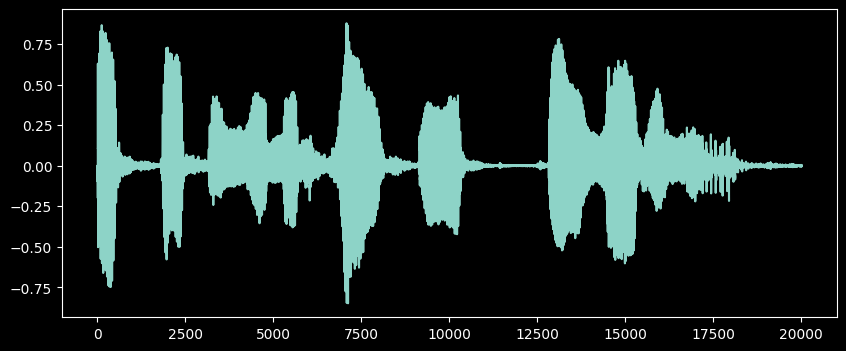

In [4]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

In [5]:
with open("weights/model_unet.json", "r") as json_file:
    loaded_model_json = json_file.read()

In [6]:
import tensorflow as tf
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [7]:
import denoising_AE as DAE

In [8]:
# loading audio with my function
audio = DAE.single_audio_file_to_numpy(example_audio, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
audio.shape

(2, 8064)

In [9]:
# loading audio as authors did (prob a better idea)
# start by predicting on training data, we can evaluate on validation/test later
real_audio_dir_prediction = "D:/for-norm/training/real"; fake_audio_dir_prediction = "D:/for-norm/training/fake"
real_audio_prediction = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"; fake_audio_prediction = "file1000.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"

real_audio = DAE.audio_files_to_numpy(real_audio_dir_prediction, real_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
fake_audio = DAE.audio_files_to_numpy(fake_audio_dir_prediction, fake_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)

real_audio.shape, fake_audio.shape # the first fake example is short so the preprocessing will cut it off

((2, 8064), (1, 0))

In [10]:
m_amp_db_audio, m_pha_audio = DAE.numpy_audio_to_matrix_spectrogram(real_audio, DIM_SQUARE_SPEC, N_FFT, HOP_LENGTH_FFT)
m_amp_db_audio.shape, m_pha_audio.shape

((2, 128, 128), (2, 128, 128))

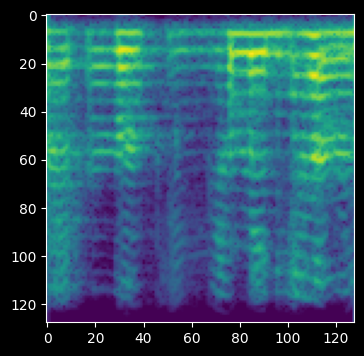

In [11]:
# which combination of axes is the actual spectrogram?
# it's definitely not the phase part since that has complex numbers
# try diff combos of the m_amp_db thing
display_spec = m_amp_db_audio[1] + m_amp_db_audio[0]

plt.figure(figsize=(10, 4))
plt.imshow(display_spec)

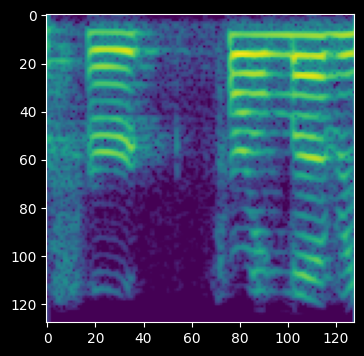

In [12]:
plt.figure(figsize=(10, 4))
plt.imshow(m_amp_db_audio[1])

In [13]:
# global scaling to have distribution -1/1
X_in = DAE.scaled_in(m_amp_db_audio)
#Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
print(X_in.shape)
#Prediction using loaded network
X_pred = loaded_model.predict(X_in)

#Rescale back the noise model
inv_sca_X_pred = DAE.inv_scaled_ou(X_pred)
#Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
#Reconstruct audio from denoised spectrogram and phase
audio_denoise_recons = DAE.matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, FRAME_LENGTH, HOP_LENGTH_FFT)
#Number of frames
nb_samples = audio_denoise_recons.shape[0]

(2, 128, 128, 1)
1/1 [==============================] - 0s 354ms/step


In [14]:
audio_denoise_recons.shape

(2, 8064)

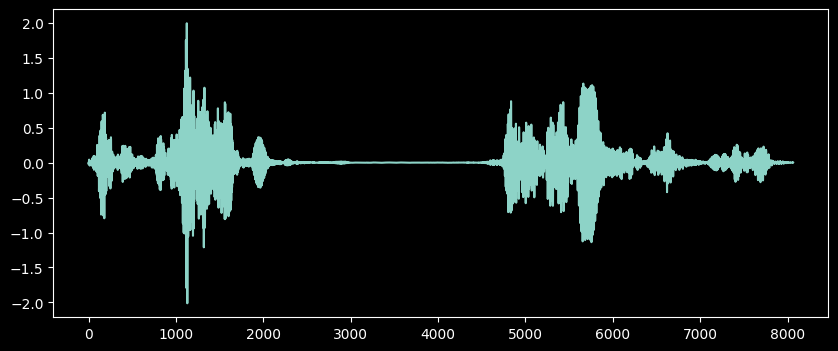

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(audio_denoise_recons[1])
plt.show()

In [16]:
display.display(display.Audio(audio_denoise_recons[1], rate=SAMPLE_RATE))

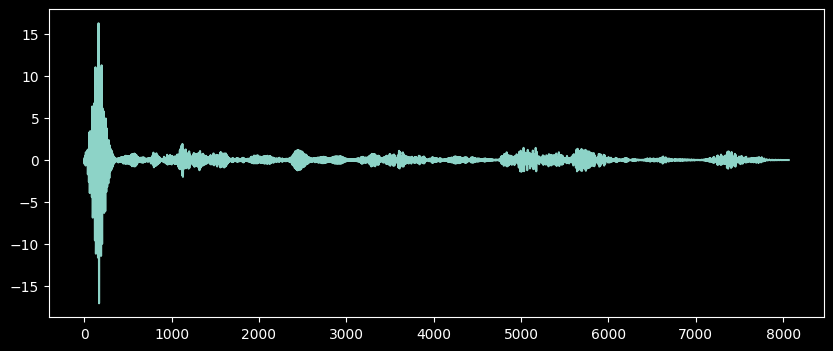

In [17]:
recons_sum = audio_denoise_recons[0] + audio_denoise_recons[1]
plt.figure(figsize=(10, 4))
plt.plot(recons_sum)
plt.show()

In [18]:
display.display(display.Audio(recons_sum, rate=SAMPLE_RATE))

In [19]:
# calculate the reconstruction error
# this function has been added to the denoising AE file
import numpy as np
def calculate_reconstruction_error(x, x_hat):
    """
    Returns the reconstruction error between two data points x and x_hat.
    We will use the MSE as the reconstruction error in our case.
    """
    error = np.square(x - x_hat).mean()
    return error

(20013,)


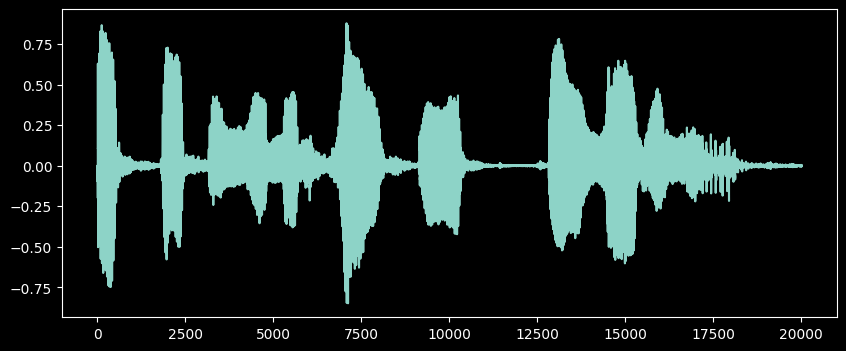

In [20]:
# need to figure out which component of the processed audio is the actual audio
# the original audio is the "waveform" variable, and the preprocessed version is the "real audio"
# plot and play both
print(waveform.shape)
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

display.display(display.Audio(waveform, rate=SAMPLE_RATE))

(16128,)


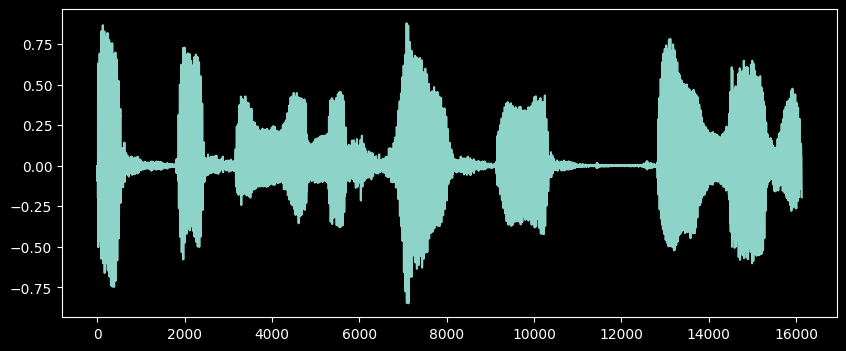

In [21]:
# so we know that the input sample is the real audio.
# which channel is the actual waveform???
# could be real_audio, real_audio[0], [1], or [0] + [1], or [[0], [1]]
# use the concatenate thing
display_audio = np.concatenate((real_audio[0], real_audio[1]))
print(display_audio.shape)

plt.figure(figsize=(10, 4))
plt.plot(display_audio)
plt.show()

display.display(display.Audio(display_audio, rate=SAMPLE_RATE))

(16128,)


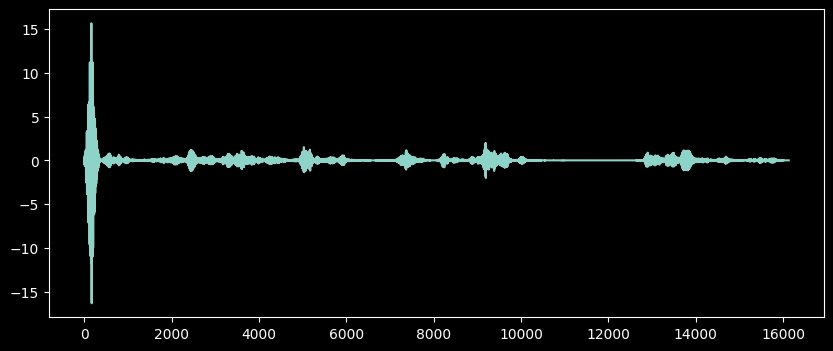

In [22]:
# let's do the same with the prediction
full_recons = np.concatenate((audio_denoise_recons[0], audio_denoise_recons[1]))
print(full_recons.shape)

plt.figure(figsize=(10, 4))
plt.plot(full_recons)
plt.show()

display.display(display.Audio(full_recons, rate=SAMPLE_RATE))

In [23]:
calculate_reconstruction_error(display_audio, full_recons)

0.44753434663708347

### Let's package all this up into functions to make it easier to test.

We can add these functions to the Python file.

In [24]:
def load_pretrained_model(display_summary=False):
    """
    Loads the pretrained model from a .json file and optionally displays a summary.
    """
    with open("weights/model_unet.json", "r") as json_file: loaded_model_json = json_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    if display_summary: loaded_model.summary()
    return loaded_model

def predict_with_model(model, audio_path, display_output=False, add_noise=False):
    """
    Makes a prediction on a single audio file with the model and optionally displays some output.
    The output will include the waveforms, spectrograms, and audio clips for the original and reconstructed audio.
    We will also report the reconstruction loss (MSE) between the original and reconstructed spectrograms and waveforms.
    """
    # loading audio into waveform as authors did
    audio_dir = "/".join(audio_path.split("/")[0:4])
    audio_pred = audio_path.split("/")[-1]
    audio = DAE.audio_files_to_numpy(audio_dir, audio_pred, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
    print(audio.shape)

    # add some noise to the audio
    # we'll set the standard deviation to 0.01 as done in the paper
    if add_noise:
        audio = audio + np.random.normal(loc=0.0, scale=0.01, size=audio.shape)

    # convert to spectrogram as the authors did
    amp_db_audio, pha_audio = DAE.numpy_audio_to_matrix_spectrogram(audio, DIM_SQUARE_SPEC, N_FFT, HOP_LENGTH_FFT)

    # make prediction (reconstruct) on the input spectrogram as the authors did
    X_in = DAE.scaled_in(amp_db_audio)
    X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
    X_pred = model.predict(X_in)

    # denoise the prediction (X_denoise is the reconstruced & denoised spectrogram)
    inv_sca_X_pred = DAE.inv_scaled_ou(X_pred)
    X_denoise = amp_db_audio - inv_sca_X_pred[:,:,:,0]

    # convert the spectrogram to the reconstructed and denoised audio
    audio_denoise_recons = DAE.matrix_spectrogram_to_numpy_audio(X_denoise, pha_audio, FRAME_LENGTH, HOP_LENGTH_FFT)

    # convert the waveforms and spectrograms to correct shape for display and reconstruction errors
    wav_in = np.concatenate((audio[0], audio[1]))
    wav_out = np.concatenate((audio_denoise_recons[0], audio_denoise_recons[1]))
    spect_in_squeeze = np.squeeze(X_in)
    spect_in = spect_in_squeeze[0] + spect_in_squeeze[1]
    spect_out = X_denoise[0] + X_denoise[1]
    
    # calculate reconstruction errors for spectrogram and waveform
    spect_error = calculate_reconstruction_error(spect_in, spect_out)
    wav_error = calculate_reconstruction_error(wav_in, wav_out)

    # display any possible output
    if display_output:

        # error
        print(f"SPECTROGRAM RECONSTRUCTION ERROR: {spect_error}")
        print(f"WAVEFORM RECONSTRUCTION ERROR: {wav_error}")

        # audio
        print("original audio:")
        display.display(display.Audio(wav_in, rate=SAMPLE_RATE))
        print("reconstructed audio:")
        display.display(display.Audio(wav_out, rate=SAMPLE_RATE))

        # plots
        fig, axs = plt.subplots(2, 2, figsize=(20, 7))
        fig.suptitle("displaying original and reconstructed audios and spectrograms (row 1 = original)")
        axs[0, 0].plot(wav_in)
        axs[0, 1].imshow(spect_in)
        axs[1, 0].plot(wav_out)
        axs[1, 1].imshow(spect_out)

(2, 8064)
1/1 [==============================] - 0s 296ms/step
SPECTROGRAM RECONSTRUCTION ERROR: 22011.39389037257
WAVEFORM RECONSTRUCTION ERROR: 0.023658427431597805
original audio:


reconstructed audio:


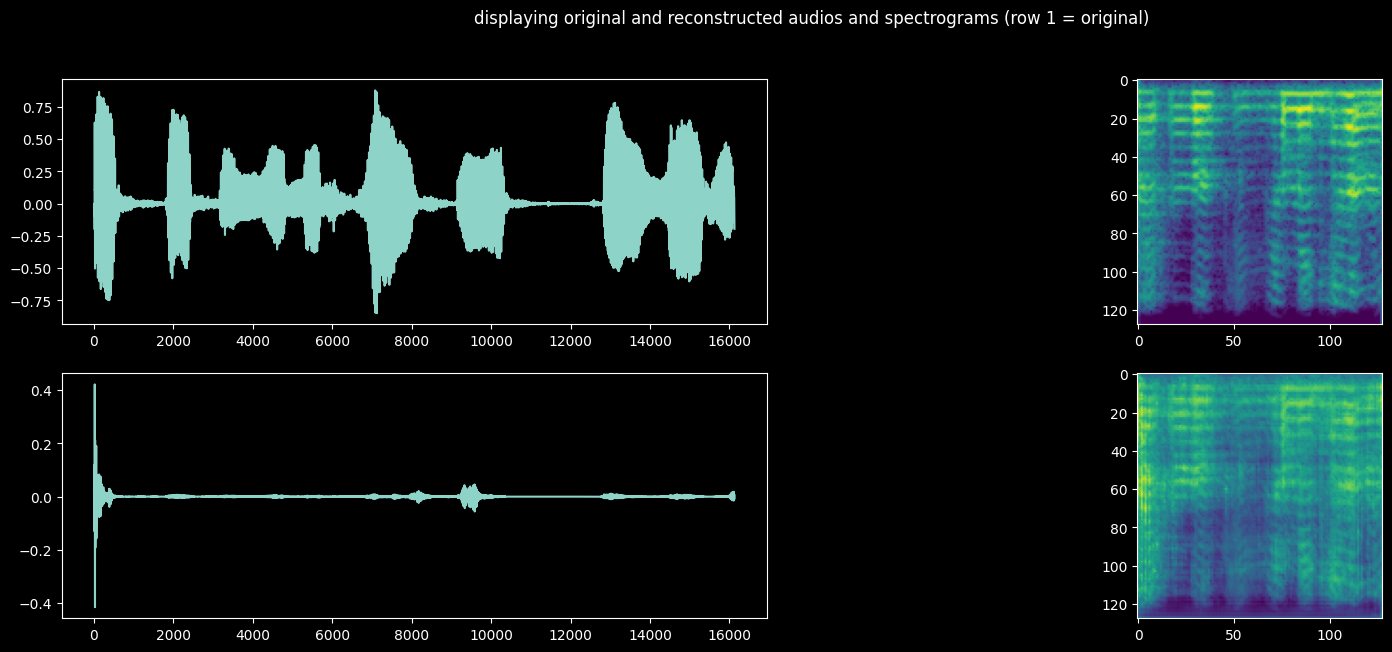

In [25]:
m = load_pretrained_model()
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predict_with_model(m, example_audio, display_output=True)

### Next, let's try adding some noise to the audio and passing that into the prediction function.

(2, 8064)
1/1 [==============================] - 0s 248ms/step
SPECTROGRAM RECONSTRUCTION ERROR: 11436.517125652646
WAVEFORM RECONSTRUCTION ERROR: 0.04094472958465067
original audio:


reconstructed audio:


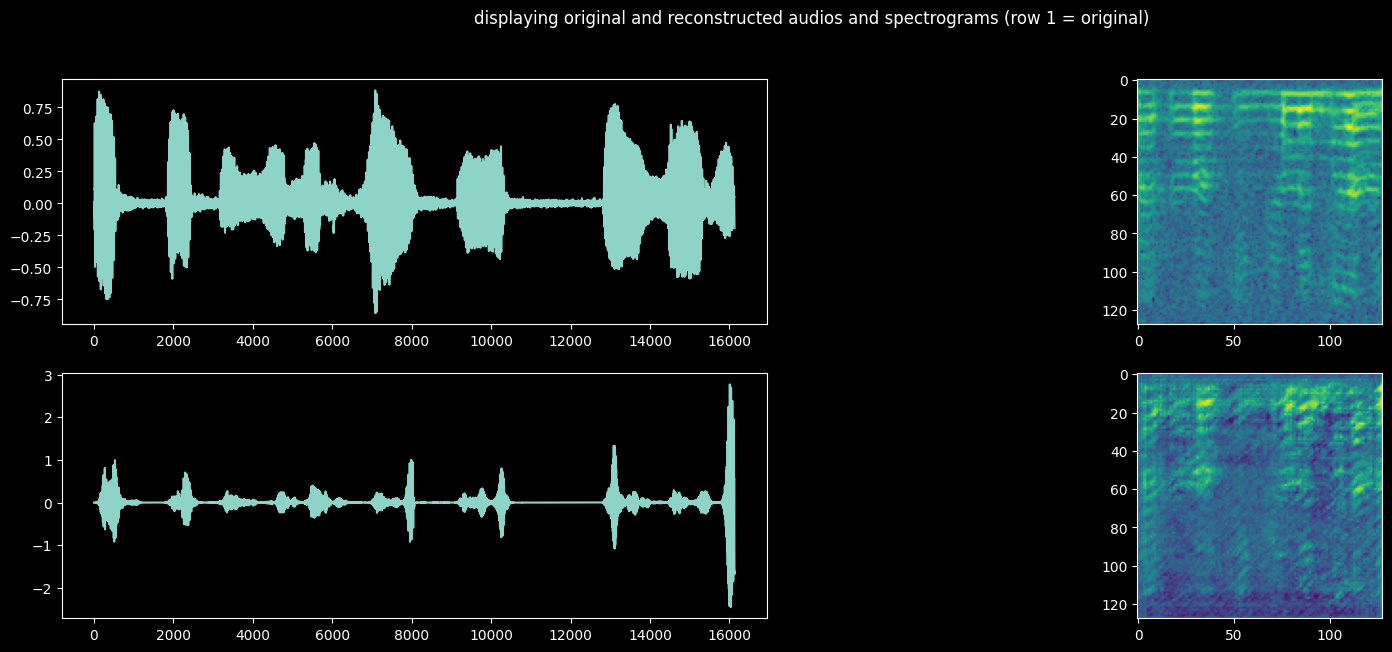

In [26]:
m = load_pretrained_model()
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predict_with_model(m, example_audio, display_output=True, add_noise=True)

### Sounds like this is working decently, but the reconstruction errors are not. However, we need to add on the classifier part. To try:

* Add the classifier without fine tuning the pretrained model, e.g., just create the CNN and train it as you did last time

* Fine tune the pretrained model (may take more time), and then do the same thing with the CNN

Let's try the first bullet point first, since that will be much easier.

In [27]:
# these are the two inputs that we need for the overall classifier
np.concatenate((X_denoise, np.squeeze(X_in))).shape
# X_denoise.shape, np.squeeze(X_in).shape

(4, 128, 128)

In [60]:
# define the CNN model as in the baseline (we already have the U-Net autoencoder)
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)), # see below cell for the input info
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    tf.keras.layers.Normalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2),
])

In [61]:
# define the full model by putting the two together
# first, we need to load the pretrained model from the json file
model1_dae = load_pretrained_model()
model1_dae.trainable = False # need these weights to be frozen
# model1_dae.summary()

In [62]:
cnn_input = tf.keras.layers.Subtract()([model1_dae.input, model1_dae.output])
final_output = cnn_model(cnn_input)
full_model = tf.keras.Model(inputs=[model1_dae.input], outputs=[final_output])

In [63]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [64]:
# now, train the full model
# use the CNN baseline code for this
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/training/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
label_names = np.array(train_ds.class_names)

Found 53868 files belonging to 2 classes.


In [65]:
# need to see the shapes of the dataset elements
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000, 1)
(64,)


In [66]:
# convert data to mono (for-norm is mono), this just means one channel
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)

In [67]:
# convert stuff to spectrograms
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT (Short-Time Fourier Transform).
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # spectrogram = tf.signal.stft(waveform, frame_length=HOP_LENGTH_FRAME, frame_step=FRAME_LENGTH)

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    # needed to update this for the shape!
    spectrogram = spectrogram[..., tf.newaxis]
    spectrogram = tf.concat([spectrogram, spectrogram], 1)[:, 0:128, 0:128, :]
    print(spectrogram.shape)
    return spectrogram

In [68]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
train_spectrogram_ds = make_spec_ds(train_ds)

(None, 128, 128, 1)


In [69]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

In [70]:
full_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [71]:
# need val data
val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/validation/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
val_spectrogram_ds = make_spec_ds(val_ds)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 10798 files belonging to 2 classes.
(None, 128, 128, 1)


In [72]:
EPOCHS = 20

# need to change the input layer shape to match the input
# this layer doesn't actually have any parameters, so it should still contain the same information
# full_model.layers[0] = tf.keras.Input(shape=(124, 129, 1)) # this gives an error without this
# full_model.summary()

# not sure why we saw early stopping, but let's try again for 20 epochs...
history = full_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
842/842 [==============================] - 574s 669ms/step - loss: 0.5318 - accuracy: 0.7313 - val_loss: 0.4675 - val_accuracy: 0.7835
Epoch 2/20
842/842 [==============================] - 545s 647ms/step - loss: 0.4302 - accuracy: 0.8043 - val_loss: 0.3659 - val_accuracy: 0.8402
Epoch 3/20
842/842 [==============================] - 551s 655ms/step - loss: 0.3725 - accuracy: 0.8359 - val_loss: 0.3346 - val_accuracy: 0.8553
Epoch 4/20
842/842 [==============================] - 552s 655ms/step - loss: 0.3447 - accuracy: 0.8501 - val_loss: 0.3345 - val_accuracy: 0.8598
Epoch 5/20
842/842 [==============================] - 552s 656ms/step - loss: 0.3195 - accuracy: 0.8636 - val_loss: 0.2923 - val_accuracy: 0.8739
Epoch 6/20
842/842 [==============================] - 555s 659ms/step - loss: 0.2976 - accuracy: 0.8739 - val_loss: 0.2698 - val_accuracy: 0.8903
Epoch 7/20
842/842 [==============================] - 549s 652ms/step - loss: 0.2825 - accuracy: 0.8829 - val_loss: 0.3178 -

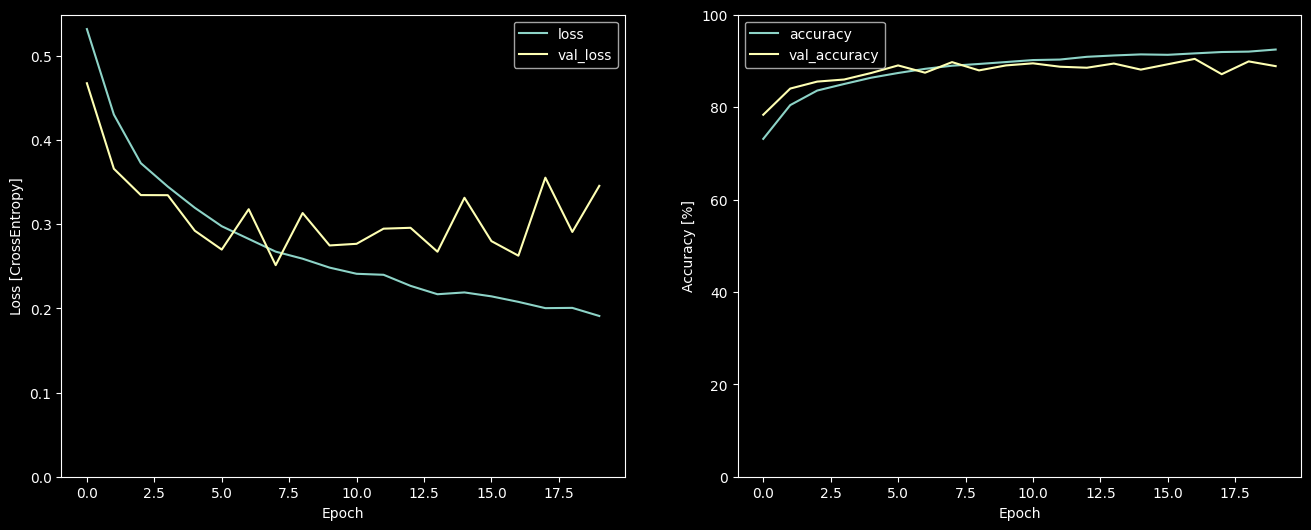

In [73]:
# see how the training progressed
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy [%]')

In [74]:
# let's see testing accuracy
# need test dataset
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/testing/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000
)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(test_ds)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 4634 files belonging to 2 classes.
(None, 128, 128, 1)


In [75]:
import seaborn as sns

73/73 [==============================] - 37s 501ms/step


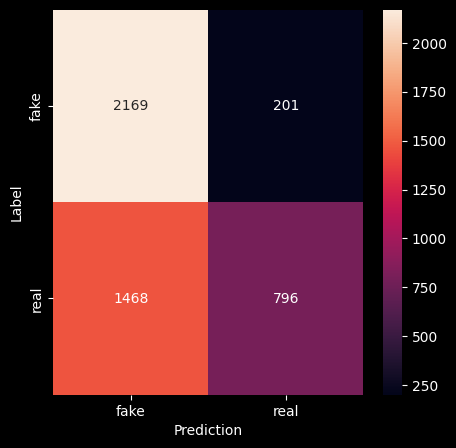

In [76]:
full_model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = full_model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Let's figure out how to use the GPU and train this thing for more epochs.

The GPU is being very buggy...

In [45]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [46]:
tf.__version__

'2.10.0'